# THIS CODE CONCATENATES WITH INVERSE VAR WEIGHTING

In [1]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

/Users/s2537809/DESI/desispec/py/desispec/qproc/qextract.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_extract(image_flux,image_var,x,hw=3) :
/Users/s2537809/DESI/desispec/py/desispec/image_model.py:27: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_proj(image,x,sigma,flux) :
/Users/s2537809/DESI/desispec/py/desispec/preproc.py:379: Num

In [2]:
""" 
Remove the objects with failed redshfit classifications.
First appplying their ZWARN flag, then with the photo-z quality flag.
"""

# Apply ZWARN Flag cut
crossmatch = crossmatch[crossmatch['ZWARN'] == 0]

# Create photo-z quality flag
crossmatch['Z_CHECK']= (crossmatch['Z']-crossmatch['Z_BEST_1'])/(1+crossmatch['Z'])
crossmatch['Z_FAILURE'] = 0  
crossmatch['Z_FAILURE'][abs(crossmatch['Z_CHECK']) > 0.1] = 1 

# Apply photo-z quality flag
crossmatch = crossmatch[crossmatch['Z_FAILURE'] == 0]
print(len(crossmatch))
print(len(crossmatch[crossmatch['Z'] < 0]))
print(len(crossmatch[crossmatch['Overall_class'] == 'SFG']))

# Remove objects with no SFR or Mass
crossmatch = crossmatch[crossmatch['SFR_cons'] != -99]
crossmatch = crossmatch[crossmatch['Mass_cons'] != -99] 


print(len(crossmatch))

7533
27
5547
7461


## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [2]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

# Wavelength Overlap Regions Weighted Average

In [3]:
def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    """
    Finds the inverse varience weighted average of two flux spectra
    
    """
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    """
    Isolates the flux and wavelength arrays of each band to non-overlapping wavelength sections
    
    """
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):
    """
    Finds the overlap of two wavelength ranges.
    Computes the inverse var weighted average flux and wavelength for th eoverlapping range 
    
    """
    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave

# Stacking Functions 

In [4]:
#stacking functions

# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        
        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()

    print('Number of spectra in wave spec=', len(wave_spec))
    
    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [8]:
#### Probably not needed 
"""
Note: NEW lengths for indexing are:

HERG = 136

RQAGN = 595

LERG = 1188

SFG = 5547
"""

var_bin = 'Mass_cons'
crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]


Overall_class = 'SFG'
total_objects = len(crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'])
bins = 6
table_size = total_objects // bins

# Create a list to store the tables
tables = []

# Loop to create each table
for i in range(bins):
    start_index = i * table_size
    end_index = (i + 1) * table_size if i < bins - 1 else total_objects
    
    # Create a table for the current segment
    current_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][start_index:end_index]
    
    # Append the table to the list
    tables.append(current_table)

# There are tables 0 to 5
#print(tables[1])

# Create a list to store the stack outputs
stack_outputs = []

# Perform operations for each table
for i, table in enumerate(tables):
    search_column_name = 'TARGETID'
    search_values = np.array(table[f'{search_column_name}'])
    
    # Extract relevant spectra
    spec = get_spectra(table, search_column_name, search_values)
    
    # Stack spectra
    stack = get_stack(spec)

    # Append the stack output to the list
    stack_outputs.append(stack)



Number of spectra = 1049
INFO:spectra.py:372:read_spectra: iotime 3.244 sec to read coadd-sv3-bright-11521.fits at 2024-01-22T12:11:12.183351


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/3482820004.py:79: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 1.753 sec to read coadd-sv3-bright-10152.fits at 2024-01-22T12:11:15.942421
INFO:spectra.py:372:read_spectra: iotime 2.228 sec to read coadd-sv3-bright-11521.fits at 2024-01-22T12:11:20.094938
INFO:spectra.py:372:read_spectra: iotime 2.592 sec to read coadd-sv3-bright-10155.fits at 2024-01-22T12:11:24.375612


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 1.956 sec to read coadd-sv3-bright-10155.fits at 2024-01-22T12:11:28.661577
INFO:spectra.py:372:read_spectra: iotime 2.874 sec to read coadd-sv3-bright-10150.fits at 2024-01-22T12:11:32.949631
INFO:spectra.py:372:read_spectra: iotime 2.069 sec to read coadd-sv3-bright-11520.fits at 2024-01-22T12:11:36.038392
INFO:spectra.py:372:read_spectra: iotime 0.470 sec to read coadd-sv3-backup-11520.fits at 2024-01-22T12:11:38.420332


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 2.804 sec to read coadd-sv3-bright-10156.fits at 2024-01-22T12:11:41.546436
INFO:spectra.py:372:read_spectra: iotime 0.164 sec to read coadd-sv1-other-11524.fits at 2024-01-22T12:11:42.649041
INFO:spectra.py:372:read_spectra: iotime 2.046 sec to read coadd-sv3-bright-10154.fits at 2024-01-22T12:11:44.885133
INFO:spectra.py:372:read_spectra: iotime 2.513 sec to read coadd-sv3-bright-10150.fits at 2024-01-22T12:11:49.270228
INFO:spectra.py:372:read_spectra: iotime 0.152 sec to read coadd-sv3-bright-11522.fits at 2024-01-22T12:11:52.510321
INFO:spectra.py:372:read_spectra: iotime 0.592 sec to read coadd-sv1-other-10147.fits at 2024-01-22T12:11:53.311888
INFO:spectra.py:372:read_spectra: iotime 0.825 sec to read coadd-sv1-other-10156.fits at 2024-01-22T12:11:54.272833
INFO:spectra.py:372:read_spectra: iotime 2.899 sec to read coadd-sv3-bright-10156.fits at 2024-01-22T12:11:57.390734
INFO:spectra.py:372:read_spectra: iotime 0.922 sec to read coadd-sv

/Users/s2537809/DESI-Mini-Project/stack_code.py:248: RuntimeWarning: divide by zero encountered in divide
  Fnorm = flux_new / np.median(flux_new[:, norm_range], axis=1, keepdims=True)
/Users/s2537809/DESI-Mini-Project/stack_code.py:248: RuntimeWarning: invalid value encountered in divide
  Fnorm = flux_new / np.median(flux_new[:, norm_range], axis=1, keepdims=True)


Stack[0]: [nan nan nan ... nan nan nan]
Stack[1]: [nan nan nan ... nan nan nan]
Stack[2]: [ 1.  1.  1. ... 45. 45. 24.]
Number of spectra = 1049
INFO:spectra.py:372:read_spectra: iotime 0.803 sec to read coadd-sv1-other-10153.fits at 2024-01-22T13:17:09.434968
INFO:spectra.py:372:read_spectra: iotime 3.359 sec to read coadd-sv3-bright-10156.fits at 2024-01-22T13:17:13.013427
INFO:spectra.py:372:read_spectra: iotime 0.876 sec to read coadd-sv1-other-10150.fits at 2024-01-22T13:17:16.080748
INFO:spectra.py:372:read_spectra: iotime 0.326 sec to read coadd-sv3-bright-10151.fits at 2024-01-22T13:17:17.290955
INFO:spectra.py:372:read_spectra: iotime 3.008 sec to read coadd-sv3-dark-10153.fits at 2024-01-22T13:17:20.426455
INFO:spectra.py:372:read_spectra: iotime 3.746 sec to read coadd-sv3-dark-10155.fits at 2024-01-22T13:17:26.978733
INFO:spectra.py:372:read_spectra: iotime 2.190 sec to read coadd-sv3-bright-10158.fits at 2024-01-22T13:17:32.333827
INFO:spectra.py:372:read_spectra: iotime 2

In [22]:

# Save the stack outputs to CSV files
for i, stack in enumerate(stack_outputs):
    
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'{Overall_class}_stack_{i}.csv', index=False)


In [63]:
# Read stack.csv
idx = 6
for i in range(idx):
    stack_df = pd.read_csv(f'{Overall_class}_stack_{i}.csv')
    stack = (stack_df['wave_spec'].values, stack_df['flux_spec'].values)
    stack_outputs.append(stack)



In [5]:



var_bin = 'Mass_cons'
crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]


Overall_class = 'SFG'
crossmatch = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}']

zbin_1 = [0.03,0.4]

total_objects = len(crossmatch[(crossmatch['Z']>zbin_1[0]) & (crossmatch['Z'] < zbin_1[1])]) 
bins_1 = 6
table_size = total_objects // bins_1

print(table_size)

zbin_2 = [0.4,0.9]

Overall_class = 'SFG'
total_objects = len(crossmatch[(crossmatch['Z']>zbin_2[0]) & (crossmatch['Z'] < zbin_2[1])])
bins_2 = 4
table_size = total_objects // bins_2

print(table_size)

zbin_3 = [0.9,1.6]

Overall_class = 'SFG'
total_objects = len(crossmatch[(crossmatch['Z']>zbin_3[0]) & (crossmatch['Z'] < zbin_3[1])])
bins_3 = 2
table_size = total_objects // bins_3

print(table_size)




510
419
386


# Start here

In [19]:
var_bin = 'Mass_cons'
crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]

Overall_class = 'SFG'
crossmatch = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}']
u_idx = len(crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'])
all_data = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:u_idx]
search_column_name = 'TARGETID'

tble_1 = crossmatch[(crossmatch['Z']>0.03) & (crossmatch['Z'] < 0.4)]
zbin_1 = tble_1[tble_1['Overall_class'] == f'{Overall_class}']
tble_2 = crossmatch[(crossmatch['Z']>0.4) & (crossmatch['Z'] < 0.9)]
zbin_2 = tble_2[tble_2['Overall_class'] == f'{Overall_class}']
tble_3 = crossmatch[(crossmatch['Z']>0.9) & (crossmatch['Z'] < 1.6)] #1.6 as this is where redrock starts to fail
zbin_3 = tble_3[tble_3['Overall_class'] == f'{Overall_class}']

tables = [all_data, zbin_1, zbin_2, zbin_3]

all_data_t = []
zbin_1_t = []
zbin_2_t = []
zbin_3_t = []
all_mass_max = []
all_mass_min = []
zbin_1_mass_max = []
zbin_1_mass_min = []
zbin_2_mass_max = []
zbin_2_mass_min = []
zbin_3_mass_max = []
zbin_3_mass_min = []

table_sizes = [6, 6, 4, 2]  # Number of bins for each table

for i, table in enumerate(tables):
    total_objects = len(table)
    table_size = total_objects // table_sizes[i]
    
    for j in range(table_sizes[i]):
        start_index = j * table_size
        end_index = (j + 1) * table_size if j < table_sizes[i] - 1 else total_objects
        
        # Create a new table for the current segment
        current_table = table[start_index:end_index]
        
        # Append the new table to the corresponding list based on the zbin
        if table is all_data:
            all_data_t.append(current_table)
            all_mass_max.append(np.max(current_table['Mass_cons']))
            all_mass_min.append(np.min(current_table['Mass_cons']))
        elif table is zbin_1:
            zbin_1_t.append(current_table)
            zbin_1_mass_max.append(np.max(current_table['Mass_cons']))
            zbin_1_mass_min.append(np.min(current_table['Mass_cons']))
        elif table is zbin_2:
            zbin_2_t.append(current_table)
            zbin_2_mass_max.append(np.max(current_table['Mass_cons']))
            zbin_2_mass_min.append(np.min(current_table['Mass_cons']))
        elif table is zbin_3:
            zbin_3_t.append(current_table)
            zbin_3_mass_max.append(np.max(current_table['Mass_cons']))
            zbin_3_mass_min.append(np.min(current_table['Mass_cons']))


"""

So zbin_1_t is a list of 6 tables


"""

print(zbin_2_t[1]['Mass_cons'])

Mass_cons
---------
    10.68
    10.68
    10.68
    10.68
    10.68
    10.68
    10.68
    10.68
    10.69
    10.69
      ...
     10.9
     10.9
     10.9
     10.9
     10.9
     10.9
     10.9
     10.9
     10.9
     10.9
     10.9
Length = 419 rows


In [ ]:
stacks_all_data = []

for table in all_data_t:
    search_values = np.array(table[f'{search_column_name}'])
    spec = get_spectra(table, search_column_name, search_values)
    stack = get_stack(spec)
    stacks_all_data.append(stack)

# Save stacks to CSV
for i, stack in enumerate(stacks_all_data):
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'all_data_stack_{i}.csv', index=False)
    print(f'Saved all_data_stack_{i}.csv')


In [7]:
stacks_zbin_1 = []

for table in zbin_1_t:
    search_values = np.array(table[f'{search_column_name}'])
    spec = get_spectra(table, search_column_name, search_values)
    stack = get_stack(spec)
    stacks_zbin_1.append(stack)

# Save stacks to CSV
for i, stack in enumerate(stacks_zbin_1):
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'zbin_1_stack_{i}.csv', index=False)
    print(f'Saved zbin_1_stack_{i}.csv')

Number of spectra = 510
INFO:spectra.py:372:read_spectra: iotime 2.704 sec to read coadd-sv3-bright-11521.fits at 2024-02-12T15:49:24.647486


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/730694531.py:79: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 1.392 sec to read coadd-sv3-bright-10152.fits at 2024-02-12T15:49:27.810685
INFO:spectra.py:372:read_spectra: iotime 1.991 sec to read coadd-sv3-bright-10150.fits at 2024-02-12T15:49:30.388165
INFO:spectra.py:372:read_spectra: iotime 2.875 sec to read coadd-sv3-bright-10156.fits at 2024-02-12T15:49:34.128311
INFO:spectra.py:372:read_spectra: iotime 1.820 sec to read coadd-sv3-bright-10154.fits at 2024-02-12T15:49:37.938555
INFO:spectra.py:372:read_spectra: iotime 0.153 sec to read coadd-sv3-bright-11522.fits at 2024-02-12T15:49:39.143876


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 0.847 sec to read coadd-sv1-other-10156.fits at 2024-02-12T15:49:40.153501
INFO:spectra.py:372:read_spectra: iotime 0.874 sec to read coadd-sv3-bright-11524.fits at 2024-02-12T15:49:41.215057
INFO:spectra.py:372:read_spectra: iotime 2.341 sec to read coadd-sv3-bright-10158.fits at 2024-02-12T15:49:43.806357


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 0.331 sec to read coadd-sv1-other-10158.fits at 2024-02-12T15:49:45.918142
INFO:spectra.py:372:read_spectra: iotime 0.809 sec to read coadd-sv1-other-10156.fits at 2024-02-12T15:49:46.910861
INFO:spectra.py:372:read_spectra: iotime 1.486 sec to read coadd-sv3-bright-10147.fits at 2024-02-12T15:49:48.580416
INFO:spectra.py:372:read_spectra: iotime 1.824 sec to read coadd-sv3-bright-11520.fits at 2024-02-12T15:49:50.789461
INFO:spectra.py:372:read_spectra: iotime 2.280 sec to read coadd-sv3-bright-10153.fits at 2024-02-12T15:49:54.440699
INFO:spectra.py:372:read_spectra: iotime 2.082 sec to read coadd-sv3-bright-10153.fits at 2024-02-12T15:49:58.013991
INFO:spectra.py:372:read_spectra: iotime 2.039 sec to read coadd-sv3-bright-10153.fits at 2024-02-12T15:50:01.631177
INFO:spectra.py:372:read_spectra: iotime 2.248 sec to read coadd-sv3-bright-10158.fits at 2024-02-12T15:50:04.597191
INFO:spectra.py:372:read_spectra: iotime 0.873 sec to read coadd-s

In [8]:
stacks_zbin_2 = []

for table in zbin_2_t:
    search_values = np.array(table[f'{search_column_name}'])
    spec = get_spectra(table, search_column_name, search_values)
    stack = get_stack(spec)
    stacks_zbin_2.append(stack)

# Save stacks to CSV
for i, stack in enumerate(stacks_zbin_2):
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'zbin_2_stack_{i}.csv', index=False)
    print(f'Saved zbin_2_stack_{i}.csv')

Number of spectra = 419
INFO:spectra.py:372:read_spectra: iotime 2.341 sec to read coadd-sv3-dark-10155.fits at 2024-02-13T08:57:51.582601


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/730694531.py:79: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 3.467 sec to read coadd-sv3-dark-11521.fits at 2024-02-13T08:57:55.654065
INFO:spectra.py:372:read_spectra: iotime 1.626 sec to read coadd-sv3-dark-10147.fits at 2024-02-13T08:57:59.423557
INFO:spectra.py:372:read_spectra: iotime 2.837 sec to read coadd-sv3-dark-10156.fits at 2024-02-13T08:58:02.991794
INFO:spectra.py:372:read_spectra: iotime 2.789 sec to read coadd-sv3-dark-11521.fits at 2024-02-13T08:58:07.517216
INFO:spectra.py:372:read_spectra: iotime 0.153 sec to read coadd-sv1-other-11524.fits at 2024-02-13T08:58:09.673820
INFO:spectra.py:372:read_spectra: iotime 2.452 sec to read coadd-sv3-dark-10156.fits at 2024-02-13T08:58:12.307835


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 3.026 sec to read coadd-sv3-dark-10158.fits at 2024-02-13T08:58:15.923228
INFO:spectra.py:372:read_spectra: iotime 2.505 sec to read coadd-sv3-dark-10155.fits at 2024-02-13T08:58:20.405563
INFO:spectra.py:372:read_spectra: iotime 2.217 sec to read coadd-sv3-dark-10155.fits at 2024-02-13T08:58:24.392463
INFO:spectra.py:372:read_spectra: iotime 0.741 sec to read coadd-sv1-other-10150.fits at 2024-02-13T08:58:26.399550
INFO:spectra.py:372:read_spectra: iotime 2.275 sec to read coadd-sv3-dark-10150.fits at 2024-02-13T08:58:28.919764
INFO:spectra.py:372:read_spectra: iotime 0.613 sec to read coadd-sv1-other-10147.fits at 2024-02-13T08:58:30.022642
INFO:spectra.py:372:read_spectra: iotime 0.633 sec to read coadd-sv1-other-10155.fits at 2024-02-13T08:58:30.845493
INFO:spectra.py:372:read_spectra: iotime 2.596 sec to read coadd-sv3-dark-10158.fits at 2024-02-13T08:58:33.644370
INFO:spectra.py:372:read_spectra: iotime 2.334 sec to read coadd-sv3-dark-101

/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 0.321 sec to read coadd-sv1-other-10158.fits at 2024-02-13T08:59:49.681507
INFO:spectra.py:372:read_spectra: iotime 0.747 sec to read coadd-sv1-other-10150.fits at 2024-02-13T08:59:50.614130
INFO:spectra.py:372:read_spectra: iotime 2.401 sec to read coadd-sv3-dark-10153.fits at 2024-02-13T08:59:53.163097
INFO:spectra.py:372:read_spectra: iotime 0.577 sec to read coadd-sv1-other-10147.fits at 2024-02-13T08:59:54.867057
INFO:spectra.py:372:read_spectra: iotime 0.615 sec to read coadd-sv1-other-11520.fits at 2024-02-13T08:59:55.733302
INFO:spectra.py:372:read_spectra: iotime 0.826 sec to read coadd-sv1-other-10153.fits at 2024-02-13T08:59:56.700967
INFO:spectra.py:372:read_spectra: iotime 0.447 sec to read coadd-sv1-other-10152.fits at 2024-02-13T08:59:57.332191
INFO:spectra.py:372:read_spectra: iotime 0.630 sec to read coadd-sv1-other-10155.fits at 2024-02-13T08:59:58.073150
INFO:spectra.py:372:read_spectra: iotime 0.819 sec to read coadd-sv1-othe

In [9]:
stacks_zbin_3 = []

for table in zbin_3_t:
    search_values = np.array(table[f'{search_column_name}'])
    spec = get_spectra(table, search_column_name, search_values)
    stack = get_stack(spec)
    stacks_zbin_3.append(stack)

# Save stacks to CSV
for i, stack in enumerate(stacks_zbin_3):
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'zbin_3_stack_{i}.csv', index=False)
    print(f'Saved zbin_3_stack_{i}.csv')

Number of spectra = 386
INFO:spectra.py:372:read_spectra: iotime 2.381 sec to read coadd-sv3-dark-10155.fits at 2024-02-13T10:05:00.369739


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/730694531.py:79: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 2.604 sec to read coadd-sv3-dark-10154.fits at 2024-02-13T10:05:03.607320


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 2.887 sec to read coadd-sv3-dark-11521.fits at 2024-02-13T10:05:08.350463
INFO:spectra.py:372:read_spectra: iotime 1.302 sec to read coadd-sv3-dark-10152.fits at 2024-02-13T10:05:11.400810


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1460/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 2.413 sec to read coadd-sv3-dark-11521.fits at 2024-02-13T10:05:14.206917
INFO:spectra.py:372:read_spectra: iotime 3.214 sec to read coadd-sv3-dark-10153.fits at 2024-02-13T10:05:18.140346
INFO:spectra.py:372:read_spectra: iotime 1.129 sec to read coadd-sv3-dark-11524.fits at 2024-02-13T10:05:21.217180
INFO:spectra.py:372:read_spectra: iotime 2.333 sec to read coadd-sv3-dark-10155.fits at 2024-02-13T10:05:23.920120
INFO:spectra.py:372:read_spectra: iotime 3.016 sec to read coadd-sv3-dark-10150.fits at 2024-02-13T10:05:27.501175
INFO:spectra.py:372:read_spectra: iotime 1.950 sec to read coadd-sv3-dark-11520.fits at 2024-02-13T10:05:31.402615
INFO:spectra.py:372:read_spectra: iotime 2.277 sec to read coadd-sv3-dark-10155.fits at 2024-02-13T10:05:34.631963
INFO:spectra.py:372:read_spectra: iotime 1.860 sec to read coadd-sv3-dark-11520.fits at 2024-02-13T10:05:37.902201
INFO:spectra.py:372:read_spectra: iotime 2.956 sec to read coadd-sv3-dark-10158.

In [10]:


# Read the CSV files

# and remormalise the flux 


def renorm(flux, wln, wln_min, wln_max):
    """
    Normalizes the flux to the median wavelength in the specified range
    """
    indices = np.where((wln >= wln_min) & (wln <= wln_max))

    flux_norm = flux / np.median(flux[indices])
    
    return flux_norm

wln_min = 4800
wln_max = 5000

all_data_stacks = []
all_data_wln = []
all_data_flux = []
all_data_flux_renorm = []

zbin_1_stacks = []
zbin_1_wln = []
zbin_1_flux = []    
zbin_1_flux_renorm = []

zbin_2_stacks = []
zbin_2_wln = []
zbin_2_flux = []
zbin_2_flux_renorm = []

zbin_3_stacks = []
zbin_3_wln = []
zbin_3_flux = []
zbin_3_flux_renorm = []

for i in range(6):
    #all_data_stack_df = pd.read_csv(f'all_data_stack_{i}.csv')
    #all_data_stack = (all_data_stack_df['wave_spec'].values, all_data_stack_df['flux_spec'].values)
    #all_data_stacks.append(all_data_stack)
    #all_data_wln.append(all_data_stack[0])
    #all_data_flux.append(all_data_stack[1])
    
    zbin_1_stack_df = pd.read_csv(f'zbin_1_stack_{i}.csv')
    zbin_1_stack = (zbin_1_stack_df['wave_spec'].values, zbin_1_stack_df['flux_spec'].values)
    zbin_1_stacks.append(zbin_1_stack)
    zbin_1_wln.append(zbin_1_stack[0])
    zbin_1_flux.append(zbin_1_stack[1])
    zbin_1_flux_renorm.append(renorm(zbin_1_stack[1], zbin_1_stack[0], wln_min, wln_max))
    
    
for i in range(4):
    zbin_2_stack_df = pd.read_csv(f'zbin_2_stack_{i}.csv')
    zbin_2_stack = (zbin_2_stack_df['wave_spec'].values, zbin_2_stack_df['flux_spec'].values)
    zbin_2_stacks.append(zbin_2_stack)
    zbin_2_wln.append(zbin_2_stack[0])
    zbin_2_flux.append(zbin_2_stack[1])
    zbin_2_flux_renorm.append(renorm(zbin_2_stack[1], zbin_2_stack[0], wln_min, wln_max))
    
for i in range(2):
    zbin_3_stack_df = pd.read_csv(f'zbin_3_stack_{i}.csv')
    zbin_3_stack = (zbin_3_stack_df['wave_spec'].values, zbin_3_stack_df['flux_spec'].values)
    zbin_3_stacks.append(zbin_3_stack)
    zbin_3_wln.append(zbin_3_stack[0])
    zbin_3_flux.append(zbin_3_stack[1])
    zbin_3_flux_renorm.append(renorm(zbin_3_stack[1], zbin_3_stack[0], wln_min, wln_max))





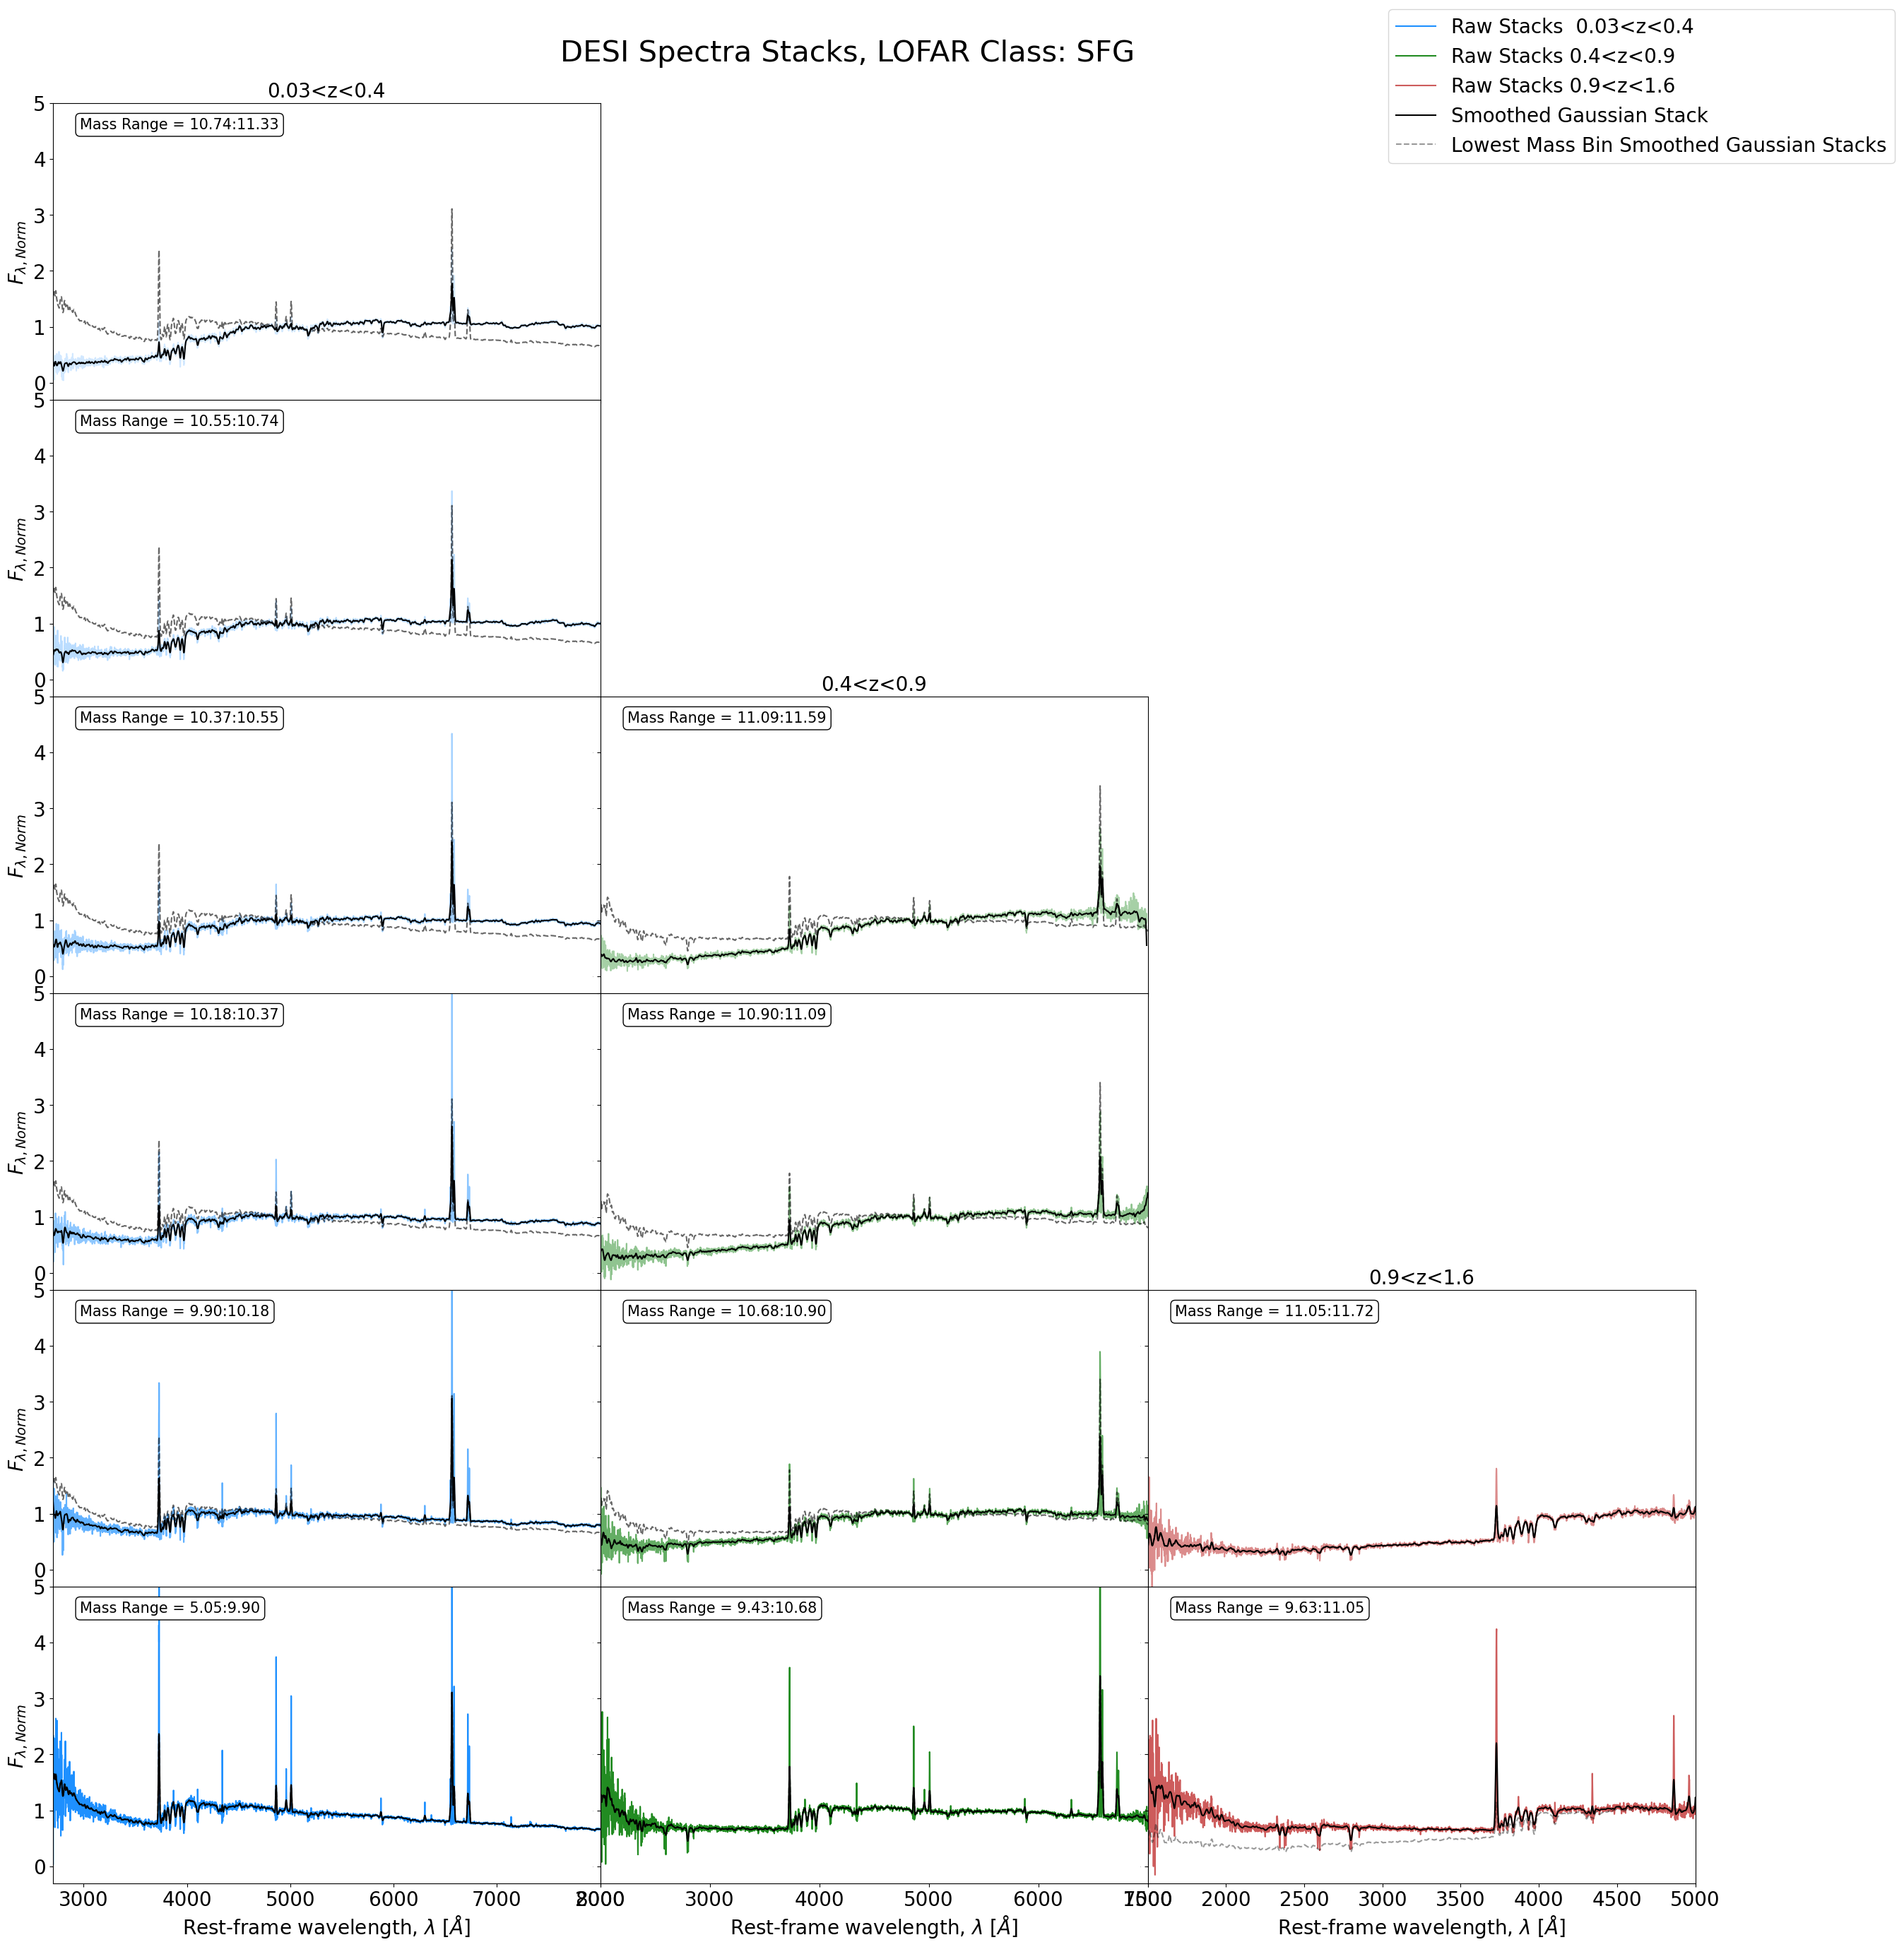

In [14]:
""""
**AS A TRIAL JUST RUN THE SSFR PLOT AND SEE IF THERES ANYTHING OTHER THAN LABELS THAT NEEDS CHANGING

"""

font = 20



# Plotting for zbin 1
fig, axes = plt.subplots(6, 3, figsize=(30, 30), sharex=False, sharey=False)

"""
****THIS PLOT IS CURRENTLY RENORMALISED TO 4800-5000 RANGE***

"""


# Define the alpha values for each row
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.7, 1.0][::-1]


for i in range(6):
        axes[5-i, 0].set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]', fontsize= font)
        axes[5-i, 0].set_ylabel('$F_{\lambda, Norm}$ ', fontsize= font)
        #axes[5-i, 0].legend(fontsize=12, loc='upper left')
        axes[5-i, 0].set_xlim(2700, 8000)
        axes[5-i, 0].set_ylim(-0.3, 5)
        axes[5-i, 0].tick_params(axis='both', which='major', labelsize=font) 
        axes[5-i, 0].text(0.05, 0.95, f'Mass Range = {zbin_1_mass_min[i]:.2f}:{zbin_1_mass_max[i]:.2f}', transform=axes[5-i, 0].transAxes, fontsize=15,
                              verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

        
        if i != 0:
            axes[5-i, 0].plot(zbin_1_wln[i], zbin_1_flux_renorm[i], color='dodgerblue', alpha=alpha_values[i])
            axes[5-i, 0].plot(zbin_1_wln[i], convolve(zbin_1_flux_renorm[i], Gaussian1DKernel(5)),color='black', alpha=1.0)
            axes[5-i, 0].plot(zbin_1_wln[0], convolve(zbin_1_flux_renorm[0], Gaussian1DKernel(5)),color='black',linestyle = '--', alpha=0.6)
        else:
            axes[5-i, 0].plot(zbin_1_wln[i], zbin_1_flux_renorm[i], 
                                label = f'Raw Stacks  0.03<z<0.4', color='dodgerblue', alpha=alpha_values[i])
            axes[5-i, 0].plot(zbin_1_wln[i], convolve(zbin_1_flux_renorm[i], Gaussian1DKernel(5)),
                                color='black', alpha=1.0)
            axes[5-i, 0].plot(zbin_1_wln[0], convolve(zbin_1_flux_renorm[0], Gaussian1DKernel(5)),
                                color='black',linestyle = '--', alpha=0.6)
            

# Plotting for zbin 2
for i in range(4):
    axes[5-i, 1].set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]', fontsize= font)
    axes[5-i, 1].set_ylabel('$F_{\lambda, Norm}$ ', fontsize= font)
    #axes[5-i, 1].legend(fontsize=12, loc='upper left')
    axes[5-i, 1].set_xlim(2000, 7000)
    axes[5-i, 1].set_ylim(-0.3, 5)
    axes[5-i, 1].tick_params(axis='both', which='major', labelsize=font)  
    axes[5-i, 1].text(0.05, 0.95, f'Mass Range = {zbin_2_mass_min[i]:.2f}:{zbin_2_mass_max[i]:.2f}', transform=axes[5-i, 1].transAxes, fontsize=15,
                              verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))


    if i != 0:
        axes[5-i, 1].plot(zbin_2_wln[i], zbin_2_flux_renorm[i], color='forestgreen', alpha=alpha_values[i])
        axes[5-i, 1].plot(zbin_2_wln[i], convolve(zbin_2_flux_renorm[i], Gaussian1DKernel(5)), color='black', alpha=1.0)
        axes[5-i, 1].plot(zbin_2_wln[0], convolve(zbin_2_flux_renorm[0], Gaussian1DKernel(5)), color='black',linestyle = '--', alpha=0.6)
    else:
        axes[5-i, 1].plot(zbin_2_wln[i], zbin_2_flux_renorm[i], 
                        label = f'Raw Stacks 0.4<z<0.9 ', color='forestgreen', alpha=alpha_values[i])
        axes[5-i, 1].plot(zbin_2_wln[i], convolve(zbin_2_flux_renorm[i], Gaussian1DKernel(5)),
                        color='black', alpha=1.0)
        axes[5-i, 1].plot(zbin_2_wln[0], convolve(zbin_2_flux_renorm[0], Gaussian1DKernel(5)),
                        color='black',linestyle = '--', alpha=0.6)
    

# Plotting for zbin 3
for i in range(2):
    axes[5-i, 2].set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]', fontsize= font)
    axes[5-i, 2].set_ylabel('$F_{\lambda, Norm}$ ', fontsize= font)
    #axes[5-i, 2].legend(fontsize=12, loc='upper left')
    axes[5-i, 2].set_xlim(1500, 5000)
    axes[5-i, 2].set_ylim(-0.3, 5)
    axes[5-i, 2].tick_params(axis='both', which='major', labelsize=font) 
    axes[5-i, 2].text(0.05, 0.95, f'Log (M/M$_{}$) = {zbin_3_mass_min[i]:.2f}:{zbin_3_mass_max[i]:.2f}', transform=axes[5-i, 2].transAxes, fontsize=15,
                              verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
 

    if i!= 0:
        axes[5-i, 2].plot(zbin_3_wln[i], zbin_3_flux_renorm[i], color='indianred', alpha=alpha_values[i])
        axes[5-i, 2].plot(zbin_3_wln[i], convolve(zbin_3_flux_renorm[i], Gaussian1DKernel(5)), color='black', alpha=1.0)
        axes[5-i, 2].plot(zbin_3_wln[1], convolve(zbin_3_flux_renorm[1], Gaussian1DKernel(5)), color='black', linestyle = '--', alpha=0.6)
    else:
        axes[5-i, 2].plot(zbin_3_wln[i], zbin_3_flux_renorm[i], 
                        label = f'Raw Stacks 0.9<z<1.6 ', color='indianred', alpha=alpha_values[i])
        axes[5-i, 2].plot(zbin_3_wln[i], convolve(zbin_3_flux_renorm[i], Gaussian1DKernel(5)),
                        label = f'Smoothed Gaussian Stack ', color='black', alpha=1.0)
        axes[5-i, 2].plot(zbin_3_wln[1], convolve(zbin_3_flux_renorm[1], Gaussian1DKernel(5)),
                        label = f'Lowest Mass Bin Smoothed Gaussian Stacks', color='black', linestyle = '--', alpha=0.4)
        

# Remove x-axis label on all plots except row 5
for i in range(6):
    for j in range(3):
        if i != 5:
            axes[i, j].set_xlabel('')
            axes[i, j].tick_params(axis='x', which='both', labelsize=0)

# Remove y-axis label on all plots except column 0
for i in range(6):
    for j in range(3):
        if j != 0:
            axes[i, j].set_ylabel('')
            axes[i, j].tick_params(axis='y', which='both', labelsize=0)

# Delete rows 0, 1, 2, 3 in column 2
for i in range(4):
    fig.delaxes(axes[i, 2])

# Delete rows 0, 1 in column 1
for i in range(2):
    fig.delaxes(axes[i, 1])

plt.subplots_adjust(top = 0.95,hspace=.0, wspace=.0)

fig.suptitle('DESI Spectra Stacks, LOFAR Class: SFG', fontsize=30)
axes[0, 0].set_title('0.03<z<0.4', fontsize=20)
axes[2, 1].set_title('0.4<z<0.9', fontsize=20)
axes[4, 2].set_title('0.9<z<1.6', fontsize=20)
fig.legend(fontsize=20, loc='upper right')


plt.show()




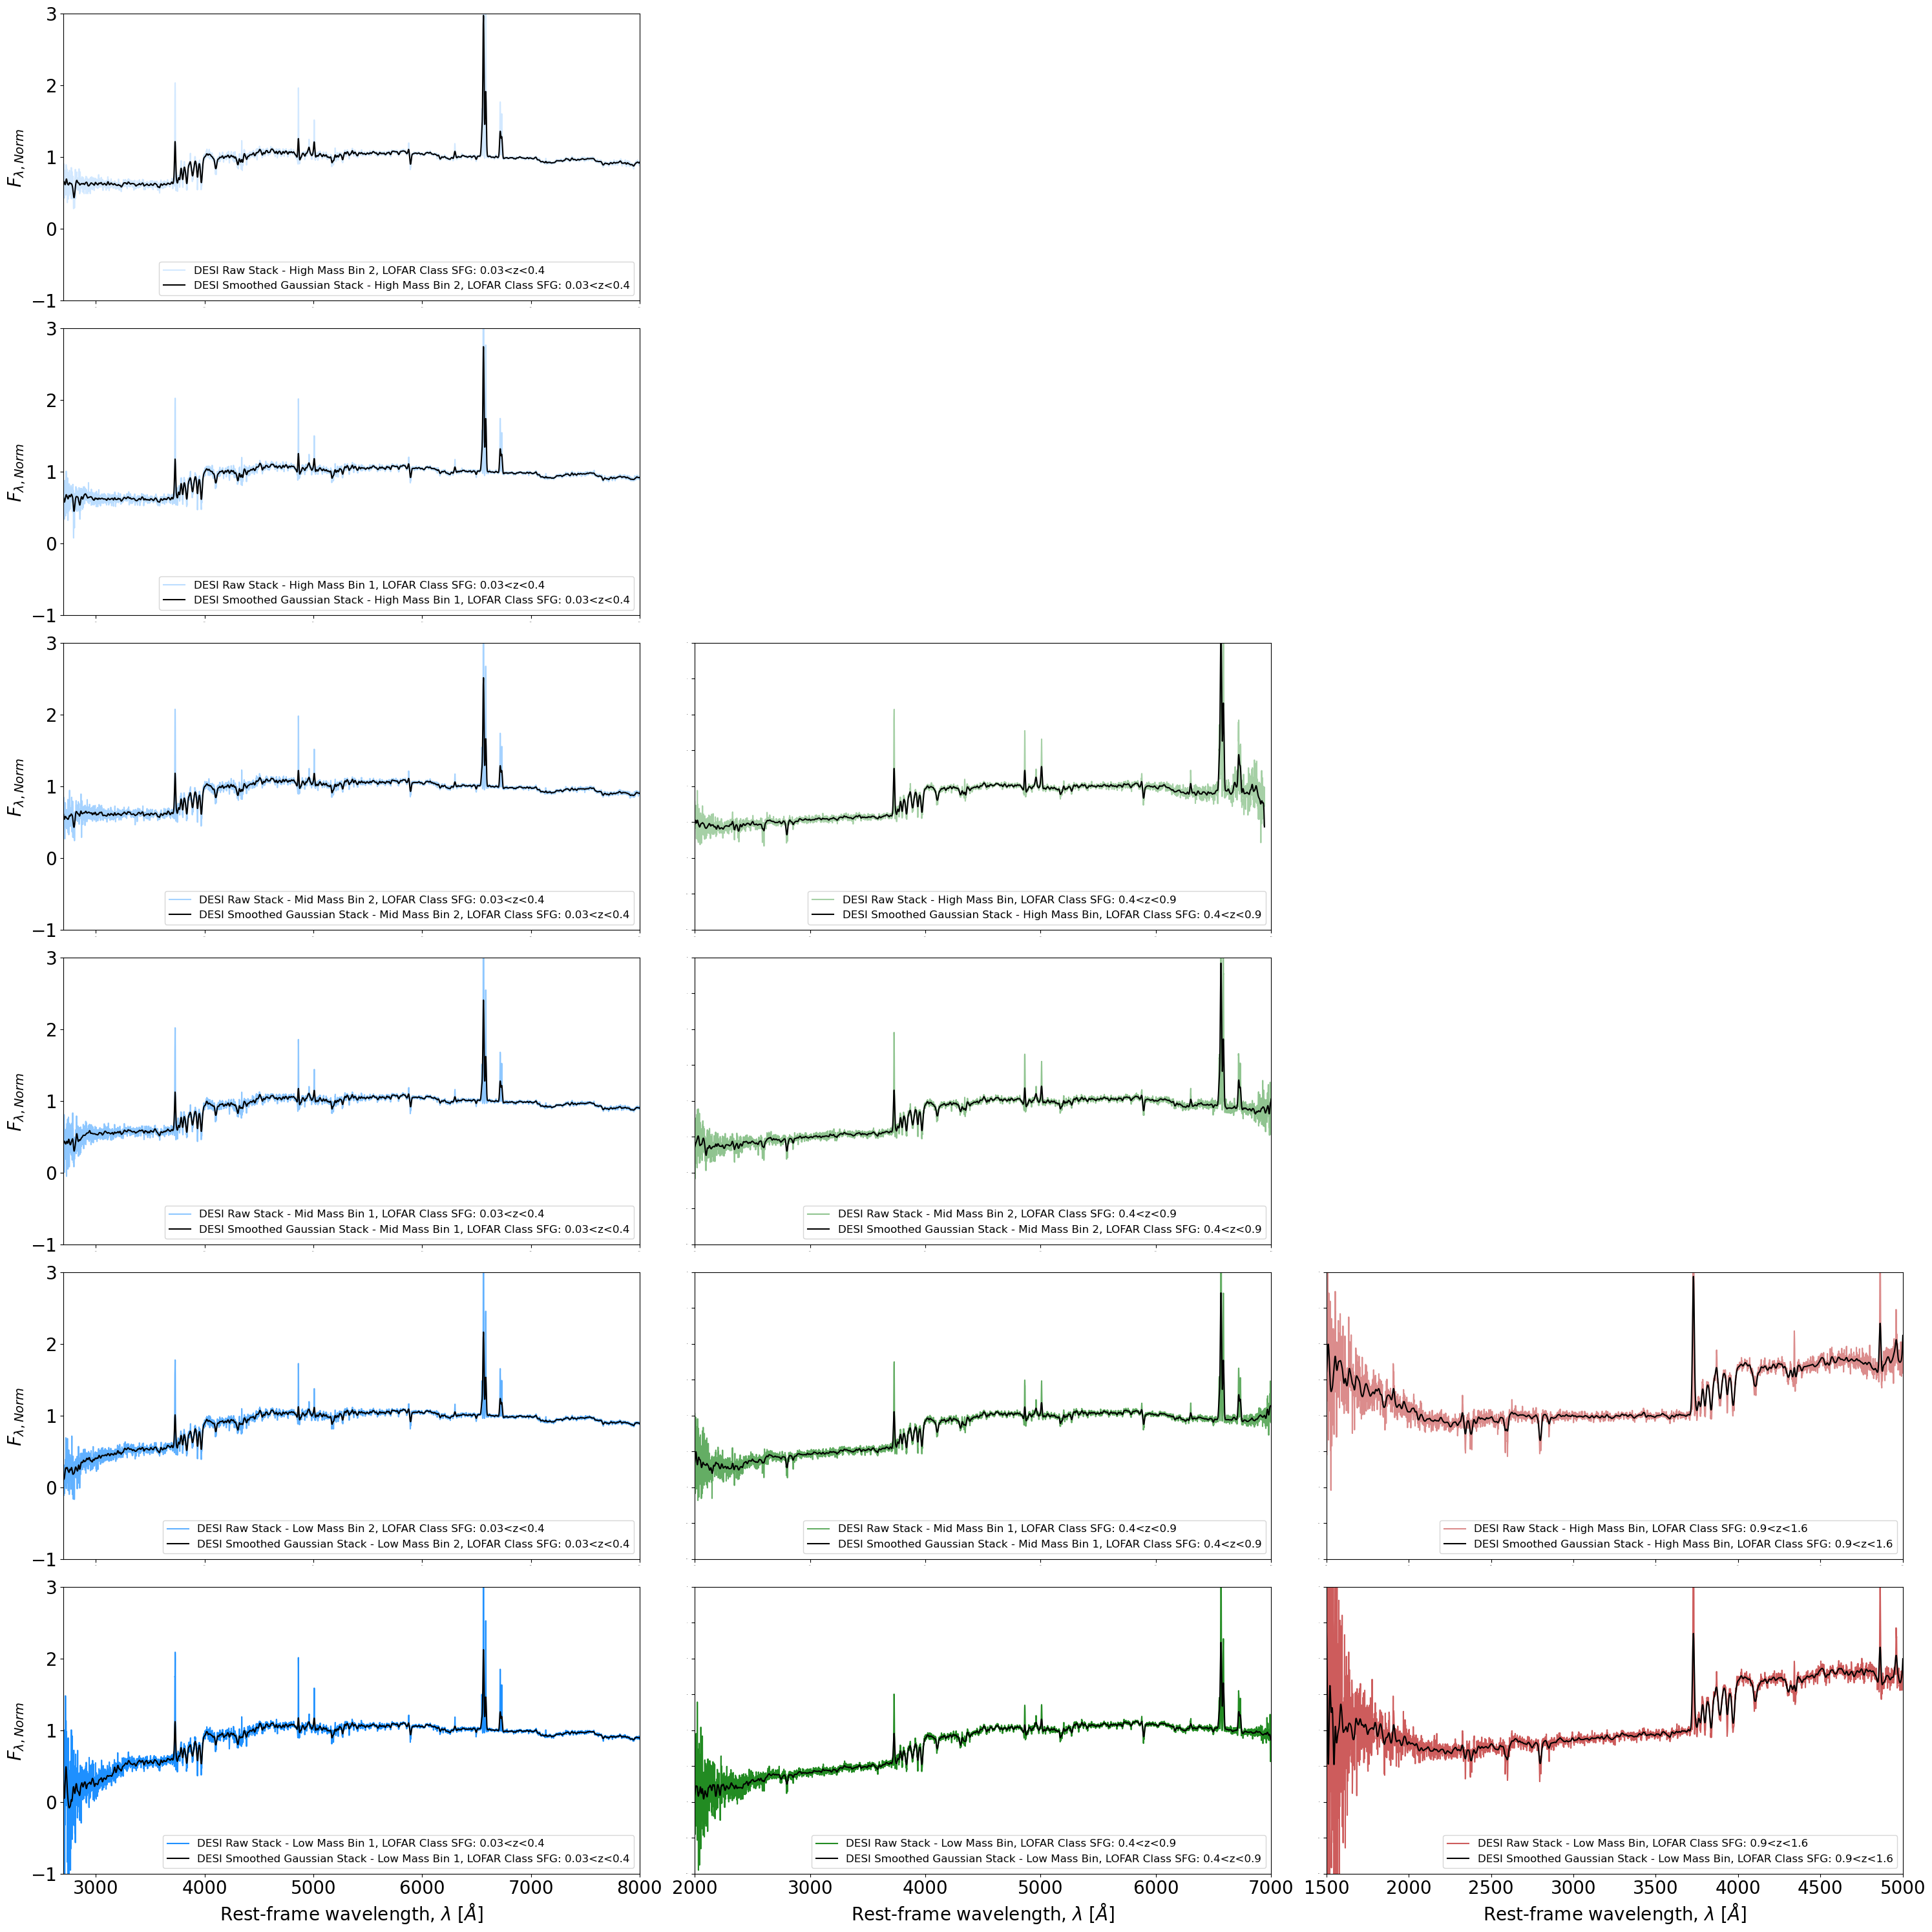

In [92]:
font = 20
# Plotting for zbin 1
fig, axes = plt.subplots(6, 3, figsize=(30, 30), sharex=False, sharey=False)

# Define the alpha values for each row
alpha_values = [0.2, 0.3, 0.4, 0.5, 0.7, 1.0][::-1]
labels_0 = ['Low Mass Bin 1', 'Low Mass Bin 2', 'Mid Mass Bin 1', 'Mid Mass Bin 2', 'High Mass Bin 1', 'High Mass Bin 2']
labels_1 = ['Low Mass Bin', 'Mid Mass Bin 1', 'Mid Mass Bin 2', 'High Mass Bin']
labels_2 = ['Low Mass Bin', 'High Mass Bin']

for i in range(6):
    axes[5-i, 0].plot(zbin_1_wln[i], zbin_1_flux[i], 
                        label = f'DESI Raw Stack - {labels_0[i]}, LOFAR Class {Overall_class}: 0.03<z<0.4', color='dodgerblue', alpha=alpha_values[i])
    axes[5-i, 0].plot(zbin_1_wln[i], convolve(zbin_1_flux[i], Gaussian1DKernel(5)),
                        label = f'DESI Smoothed Gaussian Stack - {labels_0[i]}, LOFAR Class {Overall_class}: 0.03<z<0.4', color='black', alpha=1.0)
    axes[5-i, 0].set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]', fontsize= font)
    axes[5-i, 0].set_ylabel('$F_{\lambda, Norm}$ ', fontsize= font)
    axes[5-i, 0].legend(fontsize=12, loc='lower right')
    axes[5-i, 0].set_xlim(2700, 8000)
    axes[5-i, 0].set_ylim(-1, 3)
    axes[5-i, 0].tick_params(axis='both', which='major', labelsize=font)  # Increase tick label size

# Plotting for zbin 2
for i in range(4):
    axes[5-i, 1].plot(zbin_2_wln[i], zbin_2_flux[i], 
                        label = f'DESI Raw Stack - {labels_1[i]}, LOFAR Class {Overall_class}: 0.4<z<0.9', color='forestgreen', alpha=alpha_values[i])
    axes[5-i, 1].plot(zbin_2_wln[i], convolve(zbin_2_flux[i], Gaussian1DKernel(5)),
                        label = f'DESI Smoothed Gaussian Stack - {labels_1[i]}, LOFAR Class {Overall_class}: 0.4<z<0.9', color='black', alpha=1.0)
    axes[5-i, 1].set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]', fontsize= font)
    axes[5-i, 1].set_ylabel('$F_{\lambda, Norm}$ ', fontsize= font)
    axes[5-i, 1].legend(fontsize=12, loc='lower right')
    axes[5-i, 1].set_xlim(2000, 7000)
    axes[5-i, 1].set_ylim(-1, 3)
    axes[5-i, 1].tick_params(axis='both', which='major', labelsize=font)  # Increase tick label size

# Plotting for zbin 3
for i in range(2):
    axes[5-i, 2].plot(zbin_3_wln[i], zbin_3_flux[i], 
                        label = f'DESI Raw Stack - {labels_2[i]}, LOFAR Class {Overall_class}: 0.9<z<1.6', color='indianred', alpha=alpha_values[i])
    axes[5-i, 2].plot(zbin_3_wln[i], convolve(zbin_3_flux[i], Gaussian1DKernel(5)),
                        label = f'DESI Smoothed Gaussian Stack - {labels_2[i]}, LOFAR Class {Overall_class}: 0.9<z<1.6', color='black', alpha=1.0)
    axes[5-i, 2].set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]', fontsize= font)
    axes[5-i, 2].set_ylabel('$F_{\lambda, Norm}$ ', fontsize= font)
    axes[5-i, 2].legend(fontsize=12, loc='lower right')
    axes[5-i, 2].set_xlim(1500, 5000)
    axes[5-i, 2].set_ylim(-1, 3)
    axes[5-i, 2].tick_params(axis='both', which='major', labelsize=font)  # Increase tick label size

# Remove x-axis label on all plots except row 5
for i in range(6):
    for j in range(3):
        if i != 5:
            axes[i, j].set_xlabel('')
            axes[i, j].tick_params(axis='x', which='both', labelsize=0)

# Remove y-axis label on all plots except column 0
for i in range(6):
    for j in range(3):
        if j != 0:
            axes[i, j].set_ylabel('')
            axes[i, j].tick_params(axis='y', which='both', labelsize=0)

# Delete rows 0, 1, 2, 3 in column 2
for i in range(4):
    fig.delaxes(axes[i, 2])

# Delete rows 0, 1 in column 1
for i in range(2):
    fig.delaxes(axes[i, 1])


plt.tight_layout()
plt.show()



## Plot Stacked Spectra

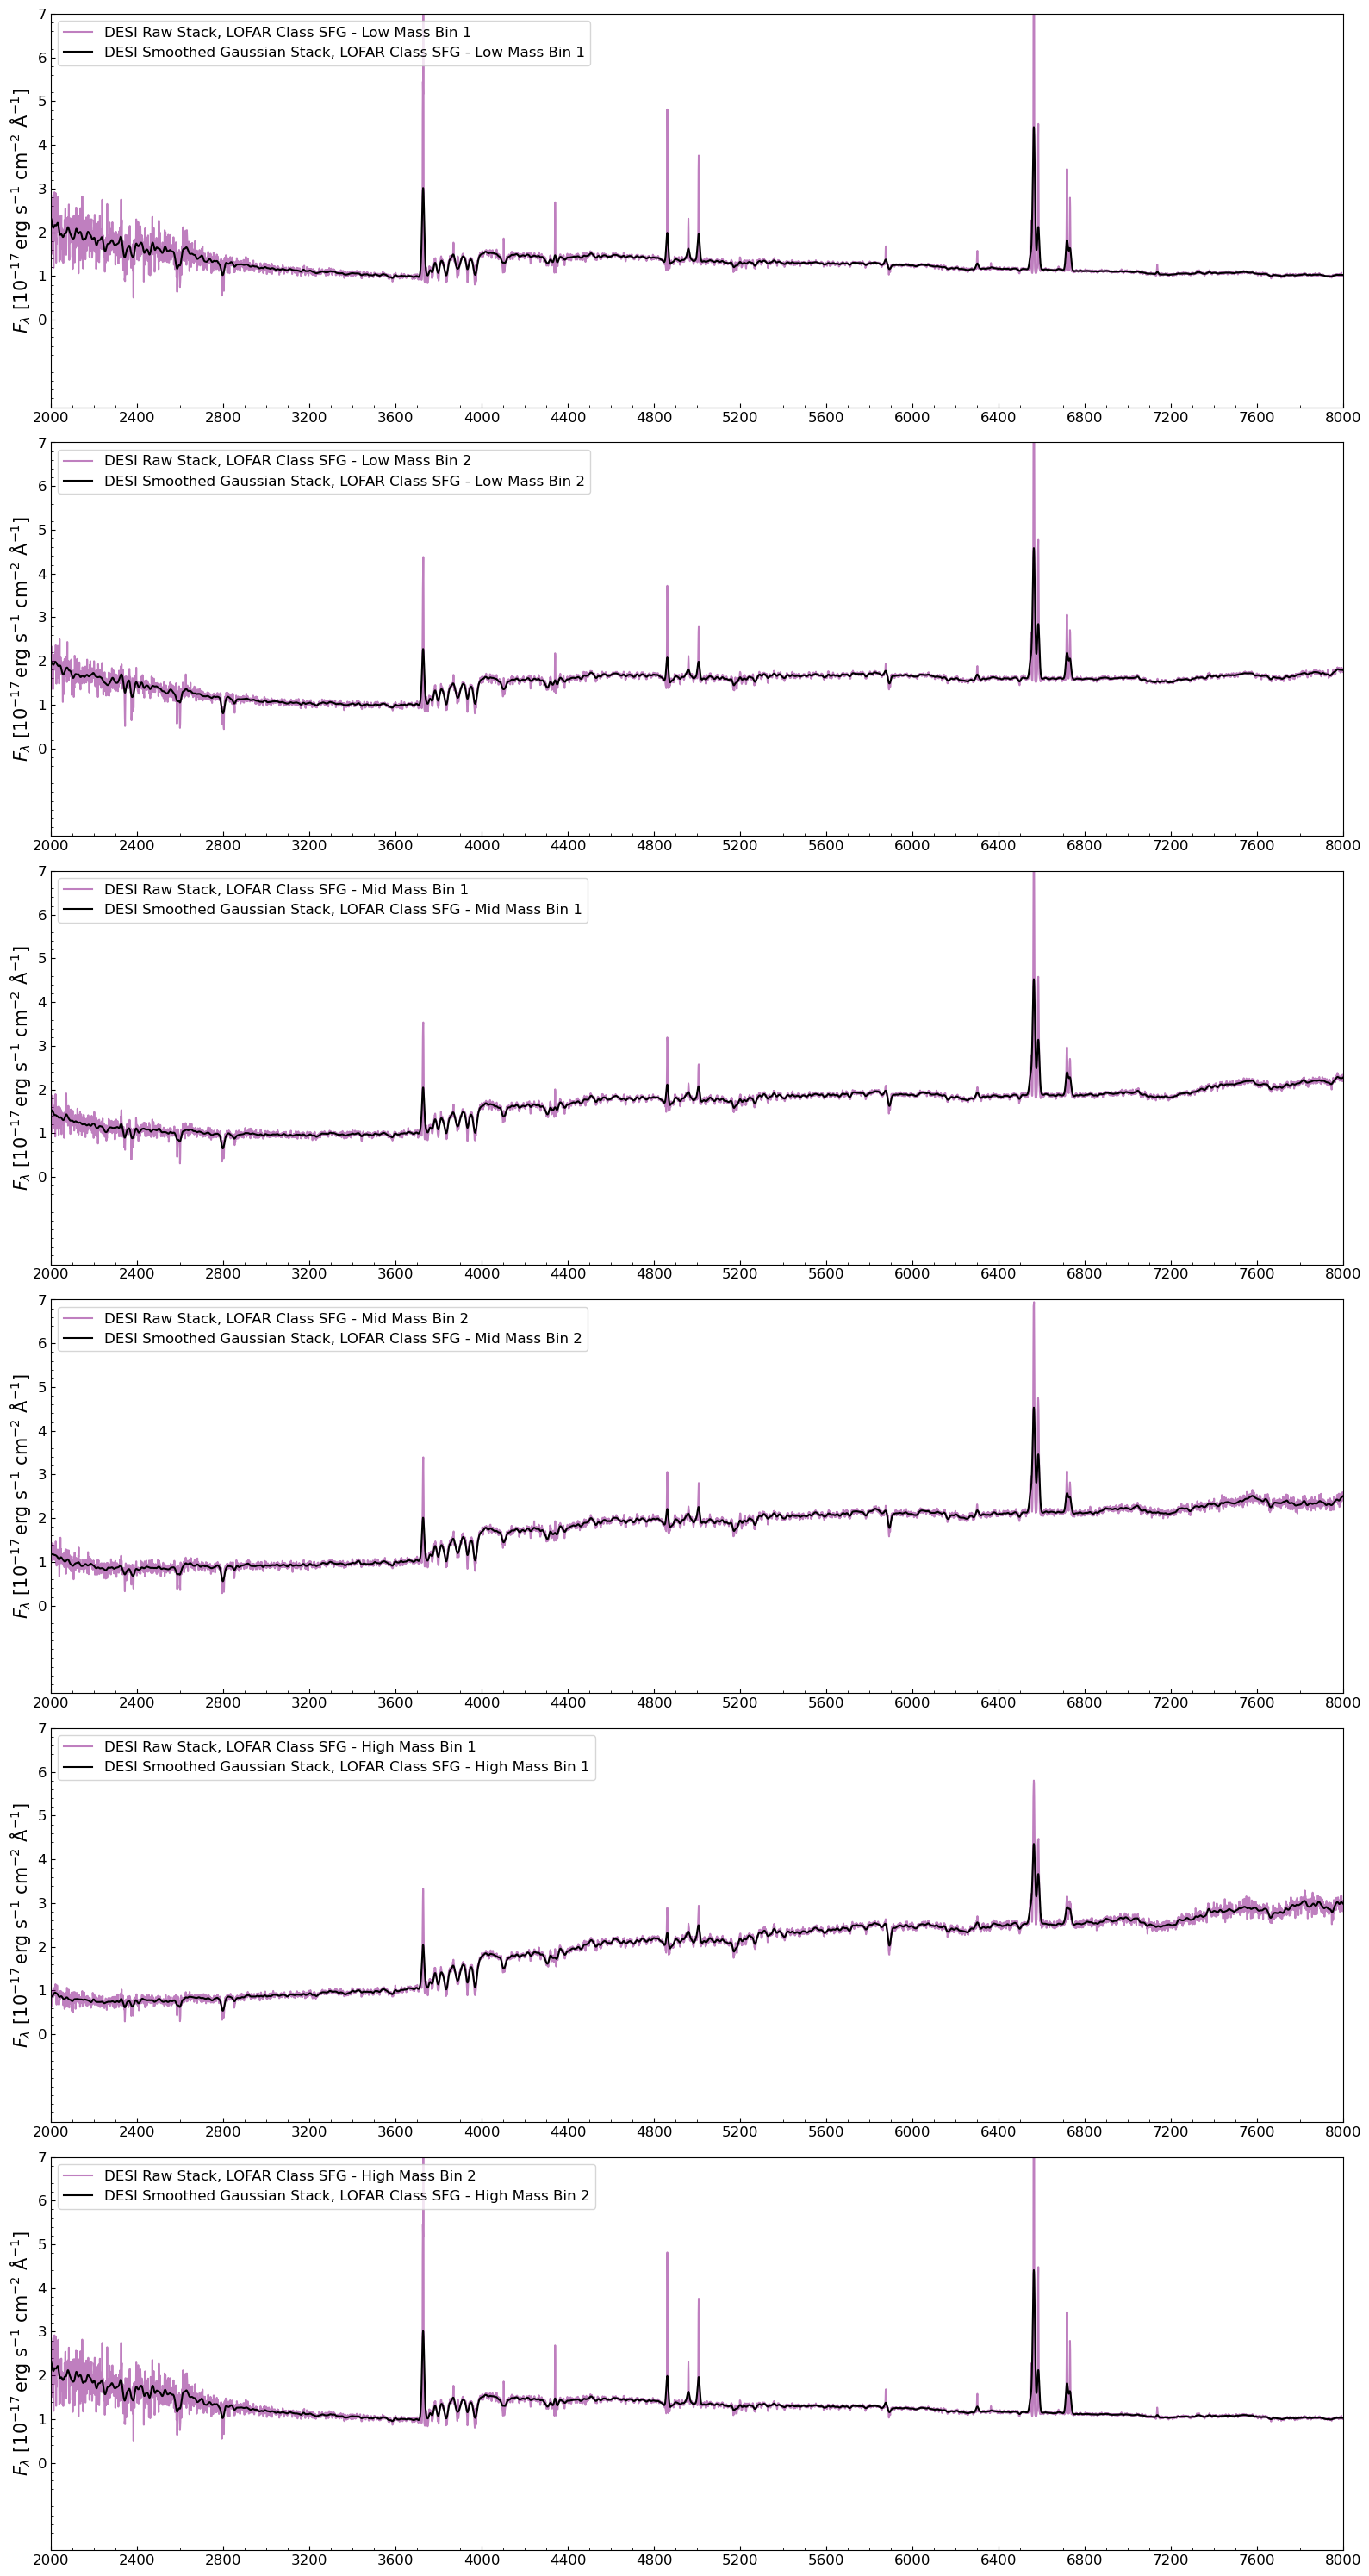

All plots saved in DESI-SFG-stack-mass.pdf


In [66]:


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack-mass.pdf'
with PdfPages(pdf_filename) as pdf:
        # Create a figure with three subplots
        fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(16, 30), sharey=True)

        #label = f'DESI Raw Stack - LOFAR Classification {Overall_class}'
        #, label = f'DESI Smoothed Gaussian Stack - LOFAR Classification {Overall_class}'

        # Change to mass
        # Define the labels for the legend
        labels = ['Low Mass Bin 1', 'Low Mass Bin 2', 'Mid Mass Bin 1', 'Mid Mass Bin 2', 'High Mass Bin 1', 'High Mass Bin 2']

        # Loop over each stack output and plot in a separate subplot
        for i, (stack_output, label) in enumerate(zip(stack_outputs, labels)):
                ax = axes[i]  # Select the current subplot
        
                 # Plot the stacked spectra
                ax.plot(stack_output[0], stack_output[1], color='purple', alpha=0.5,
                        label=f'DESI Raw Stack, LOFAR Class {Overall_class} - {label}')
                
                # Plot the convolved spectra
                ax.plot(stack_output[0], convolve(stack_output[1], Gaussian1DKernel(5)),
                        color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class} - {label}')
                                
                if i == len(stack_outputs) - 1:
                        ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]', fontsize=15)

                ax.set_ylabel('$F_{\lambda}$ [$10^{-17} \, \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$]')
                #ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
                ax.set_ylim(-2, 6)
                ax.set_xlim(2000, 8000)
                ax.set_xticks(range(2000, 8001, 400))
                ax.set_yticks(range(0, 8, 1))
                ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
                ax.minorticks_on()
                ax.xaxis.label.set_size(15)
                ax.yaxis.label.set_size(15)
                ax.legend(fontsize='large', loc ='upper left')

                # Adjust layout for better spacing
                plt.tight_layout()
                
                
                
               
        # Save the current plot to the PDF file
        pdf.savefig(fig)
# Show the plot
plt.show()
plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/1776432223.py:48: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  pdf.savefig(fig)


ValueError: x has 6950 columns but y has 6934 columns

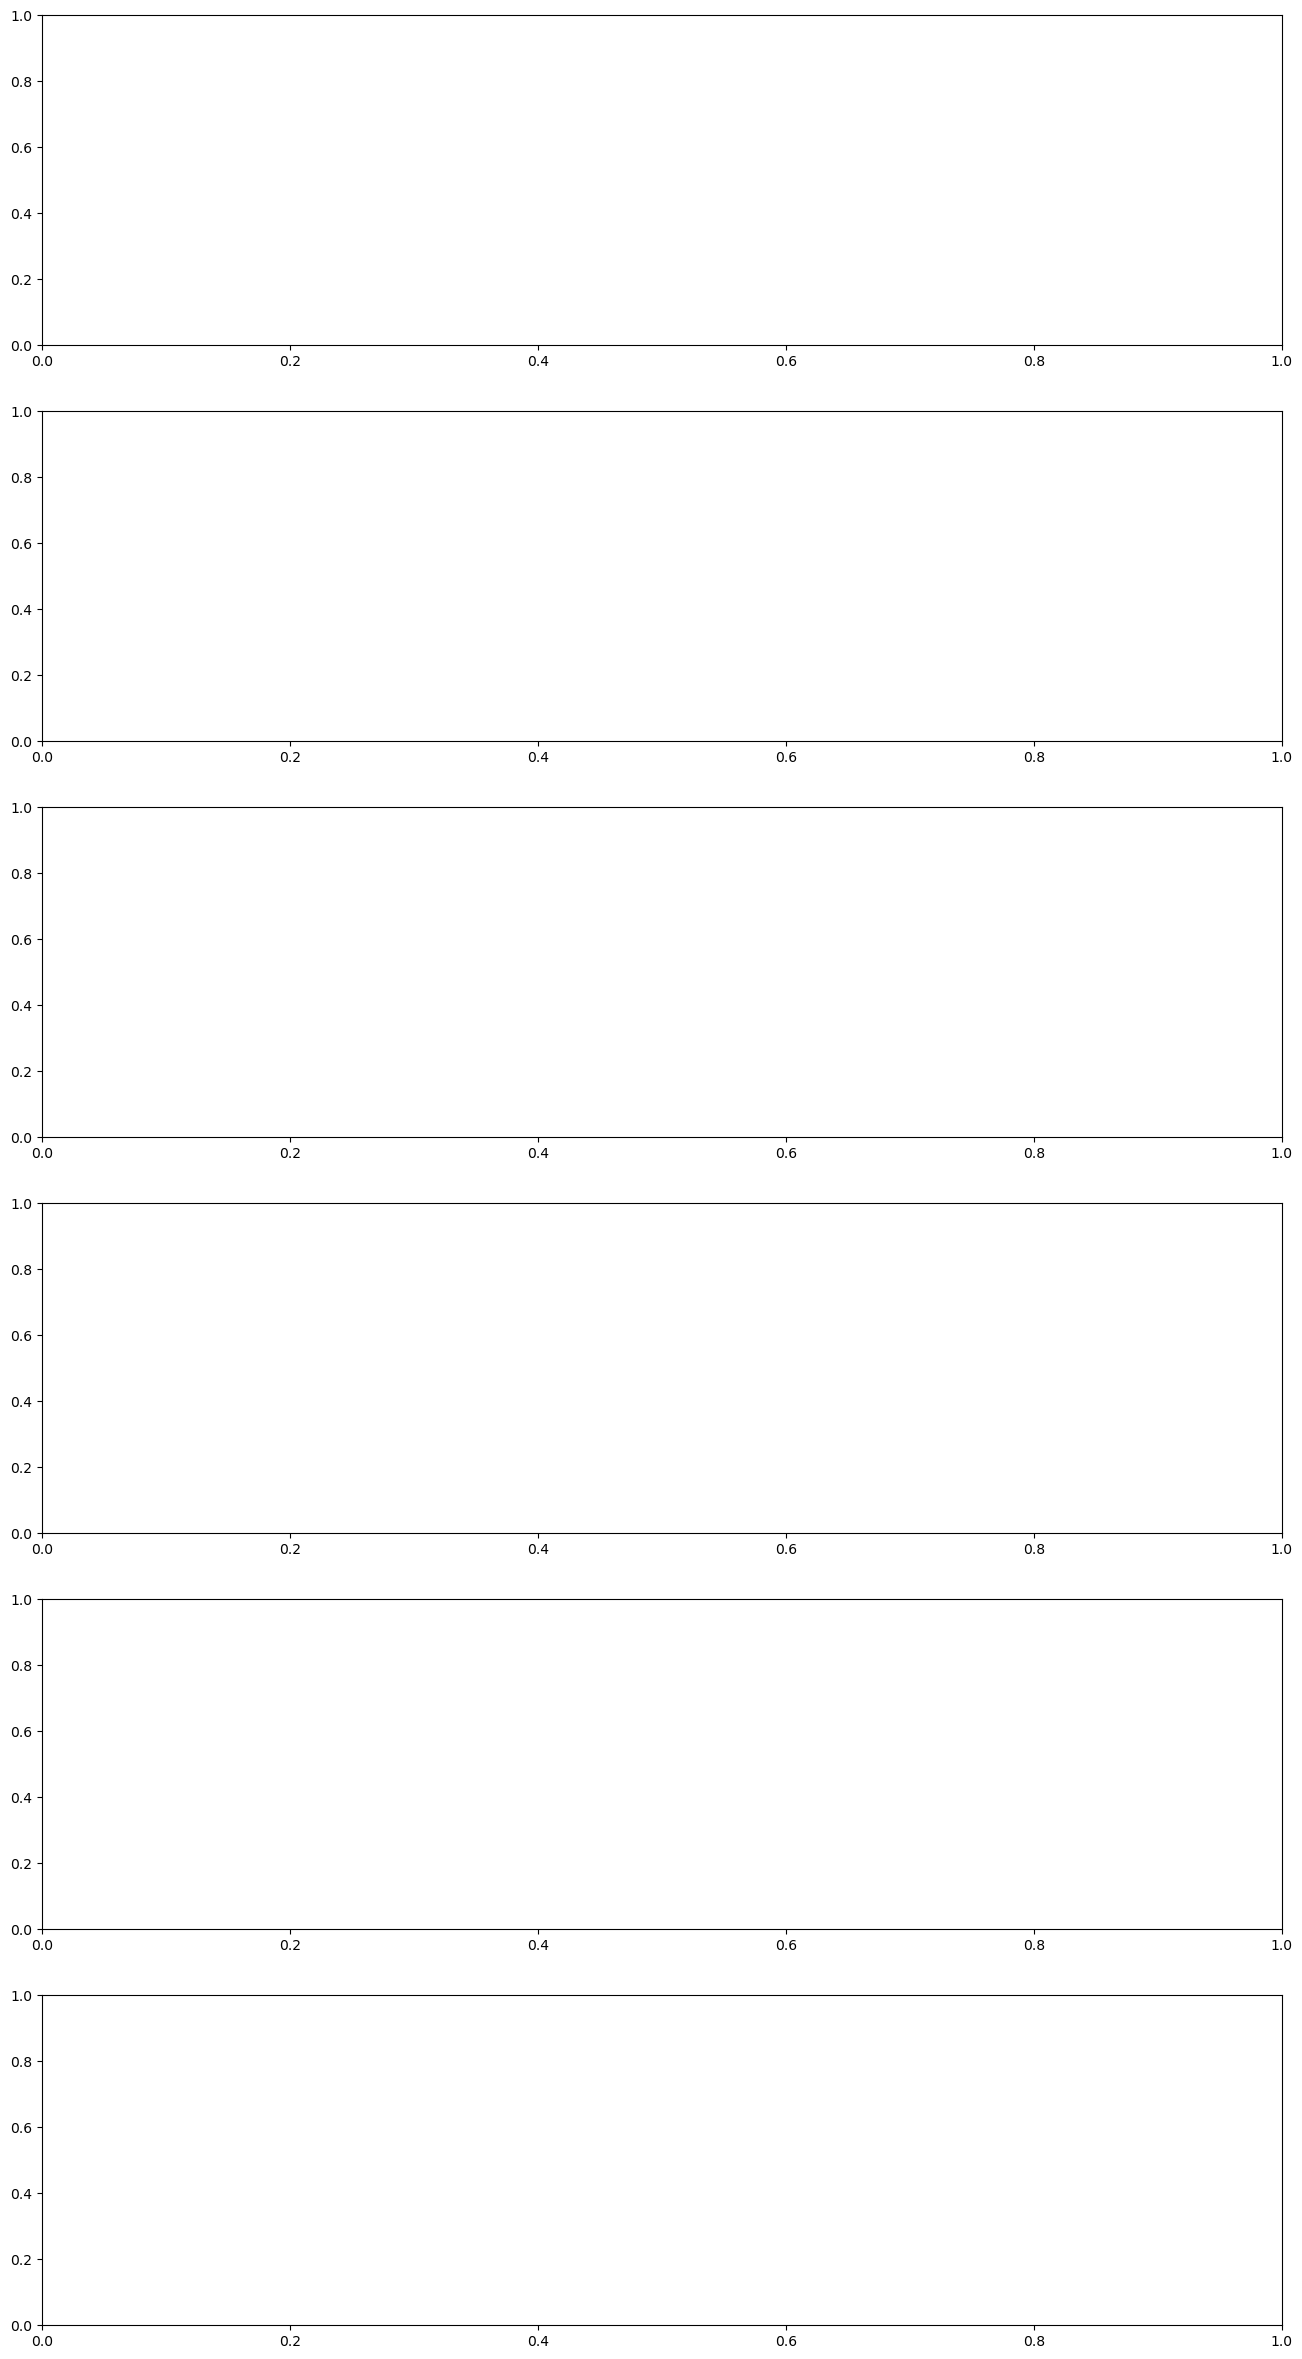

In [145]:


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack-mass.pdf'
with PdfPages(pdf_filename) as pdf:
        # Create a figure with three subplots
        fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(16, 30), sharey=True)

        #label = f'DESI Raw Stack - LOFAR Classification {Overall_class}'
        #, label = f'DESI Smoothed Gaussian Stack - LOFAR Classification {Overall_class}'

        # Change to mass
        # Define the labels for the legend
        labels = ['Low Mass Bin 1', 'Low Mass Bin 2', 'Mid Mass Bin 1', 'Mid Mass Bin 2', 'High Mass Bin 1']

        # Loop over each stack output and plot in a separate subplot
        for i, (stack_output, label) in enumerate(zip(stacks_outputs_1, labels)):
                ax = axes[i]  # Select the current subplot
        
                 # Plot the stacked spectra
                ax.plot(stacks_outputs_1[0], stacks_outputs_1[1], color='purple', alpha=0.5,
                        label=f'DESI Raw Stack, LOFAR Class {Overall_class} - {label}')
                
                # Plot the convolved spectra
                ax.plot(stacks_outputs_1[0], convolve(stacks_outputs_1[1], Gaussian1DKernel(5)),
                        color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class} - {label}')
                                
                if i == len(stacks_outputs_1) - 1:
                        ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]', fontsize=15)

                ax.set_ylabel('$F_{\lambda}$ [$10^{-17} \, \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$]')
                #ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
                ax.set_ylim(-2, 6)
                ax.set_xlim(2000, 8000)
                ax.set_xticks(range(2000, 8001, 400))
                ax.set_yticks(range(0, 8, 1))
                ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
                ax.minorticks_on()
                ax.xaxis.label.set_size(15)
                ax.yaxis.label.set_size(15)
                ax.legend(fontsize='large', loc ='upper left')

                # Adjust layout for better spacing
                plt.tight_layout()
                
                
                
               
        # Save the current plot to the PDF file
        pdf.savefig(fig)
# Show the plot
plt.show()
plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')


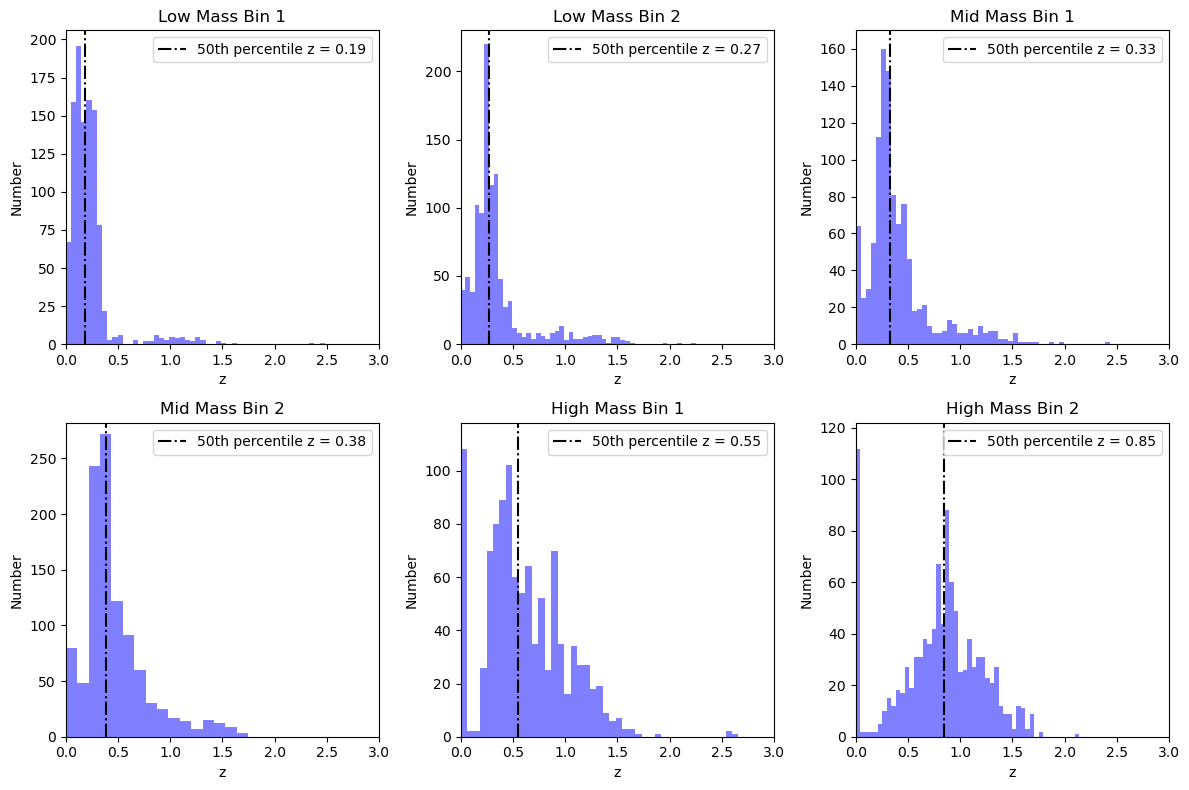

In [13]:
labels = ['Low Mass Bin 1', 'Low Mass Bin 2', 'Mid Mass Bin 1', 'Mid Mass Bin 2', 'High Mass Bin 1', 'High Mass Bin 2']




num_tables = len(tables)
num_rows = 2
num_cols = 3
percentile = 50

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Adjust the figure size as needed

for i, (table, label) in enumerate(zip(tables, labels)):
    z_cut = np.percentile(table['Z'], percentile)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]

    counts, bins, _ = ax.hist(table['Z'], bins=50, color='blue', alpha=0.5)
    ax.set_xlabel('z')
    ax.set_ylabel('Number')
    ax.set_title(f'{label}')
    ax.set_xlim(0, 3)
    
    # Set y-limit to the maximum value in the histogram
    ax.set_ylim(0, max(counts)+10)
    
    ax.vlines(z_cut, ymin=0, ymax=max(counts)+10, colors='black', linestyles='-.', label = f'{percentile}th percentile z = {z_cut:.2f}')
    ax.legend()
    
# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [14]:

"""

Add in some bounds to remove the upper and lower 10% of each spectra as noise reduction

"""

def bounds(stack_array):
        bound = 0
        l_bound = len(stack_array)*bound
        u_bound = len(stack_array)-(len(stack_array)*bound)

        return int(l_bound), int(u_bound)




/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20733/3254001613.py:68: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  pdf.savefig(fig)


KeyError: 0

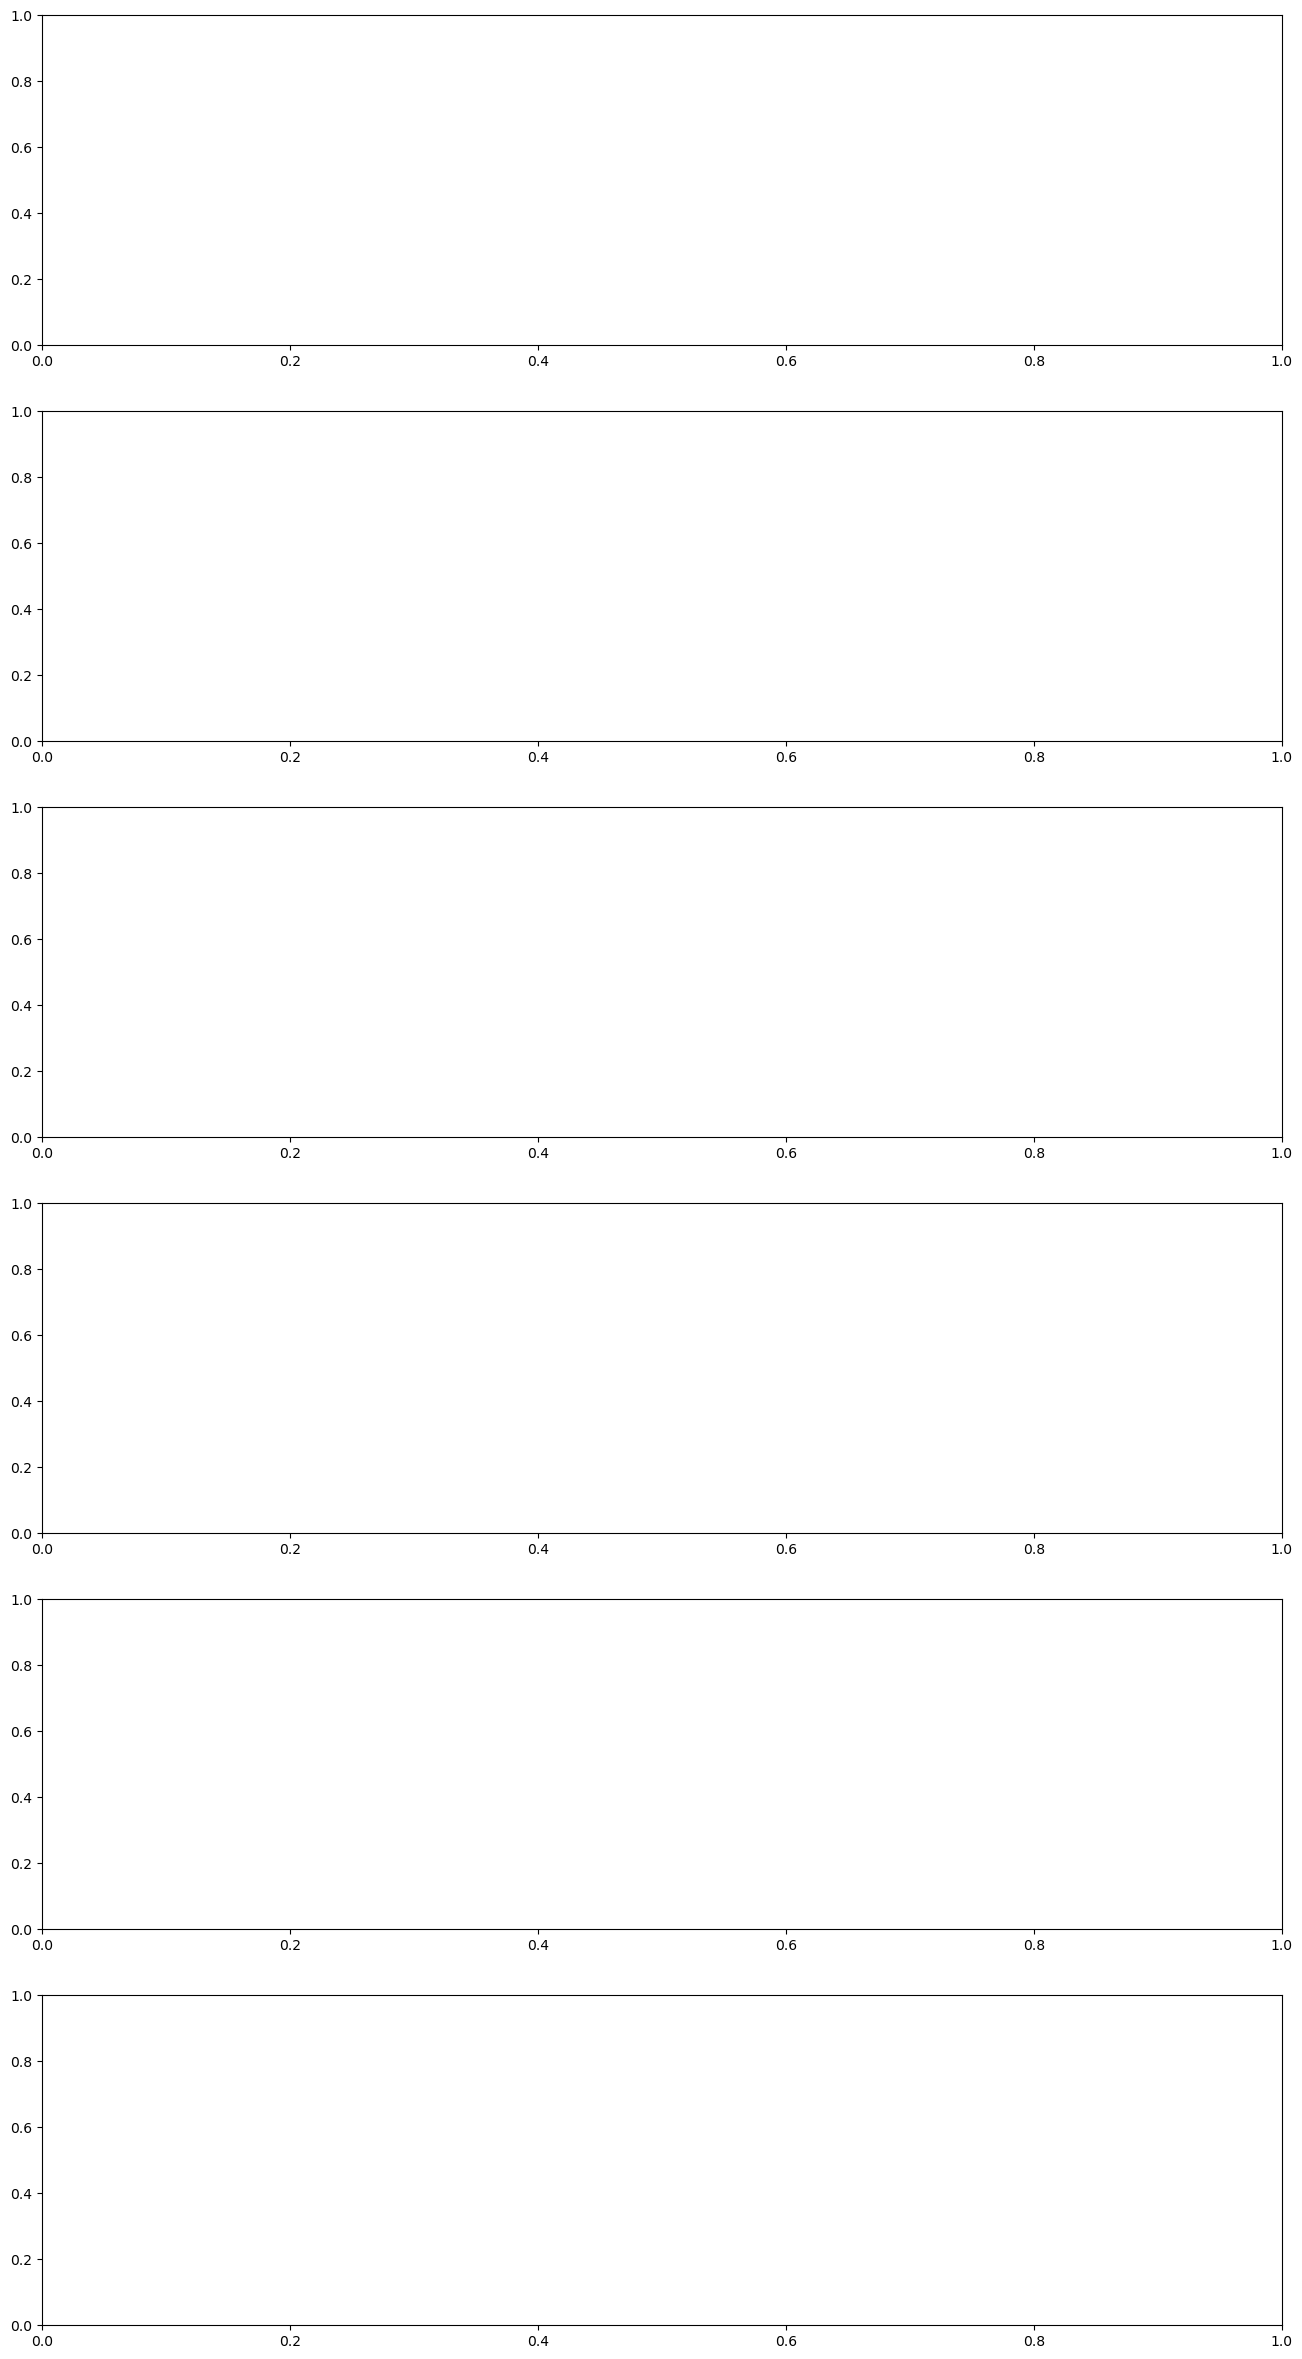

In [125]:
"""
Splitting by reshift recovers Halpha but could still split different bins
(see histograms for where the difference in the redshift bins lies)
computationally longggg though maybe try loop out the get spectra function from the stacks function

st0 = bounds(SFG_stacks['zbin=0']['wln'])
st1 = bounds(SFG_stacks['zbin=1']['wln'])
st2 = bounds(SFG_stack['zbin=0']['wln'])


"""

# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack-mass.pdf'
with PdfPages(pdf_filename) as pdf:
        # Create a figure with three subplots
        fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(16, 30), sharey=True)

        


        # Change to mass
        # Define the labels for the legend
        labels = ['Low Mass Bin 1', 'Low Mass Bin 2', 'Mid Mass Bin 1', 'Mid Mass Bin 2', 'High Mass Bin 1', 'High Mass Bin 2']

        # Loop over each stack output and plot in a separate subplot
        for i, (stack_output, stacks_output,label) in enumerate(zip(stack_outputs,stacks_outputs, labels)):
                ax = axes[i]  # Select the current subplot
        
                # Plot the stacked spectra
                ax.plot(stacks_output[0],stacks_output[1], 
                        label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z < 0.75', color='blue', alpha=0.2)
                ax.plot(stacks_output[0],stacks_output[1], 
                        label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z > 0.75', color='red', alpha=0.2)
        
                
                # Plot the convolved spectra
                ax.plot(stacks_output[0],convolve(stacks_output[1], Gaussian1DKernel(5)), 
                        color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z < 0.75')
                ax.plot(stacks_output[0],convolve(stacks_output[1], Gaussian1DKernel(5)), 
                        color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z < 0.75')
        



                if i == len(stack_outputs) - 1:
                        ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]', fontsize=15)

                ax.set_ylabel('$F_{\lambda}$ [$10^{-17} \, \mathrm{erg\ s^{-1}\ cm^{-2}\ \AA^{-1}}$]')
                #ax.set_xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')
                ax.set_ylim(-2, 6)
                ax.set_xlim(1000, 8000)
                ax.set_xticks(range(1000, 8001, 400))
                ax.set_yticks(range(0, 8, 1))
                ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
                ax.minorticks_on()
                ax.xaxis.label.set_size(15)
                ax.yaxis.label.set_size(15)
                ax.legend(fontsize='large', loc ='upper left')

                # Adjust layout for better spacing
                plt.tight_layout()
                
                
                
               
        # Save the current plot to the PDF file
        pdf.savefig(fig)
# Show the plot
plt.show()
plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')
